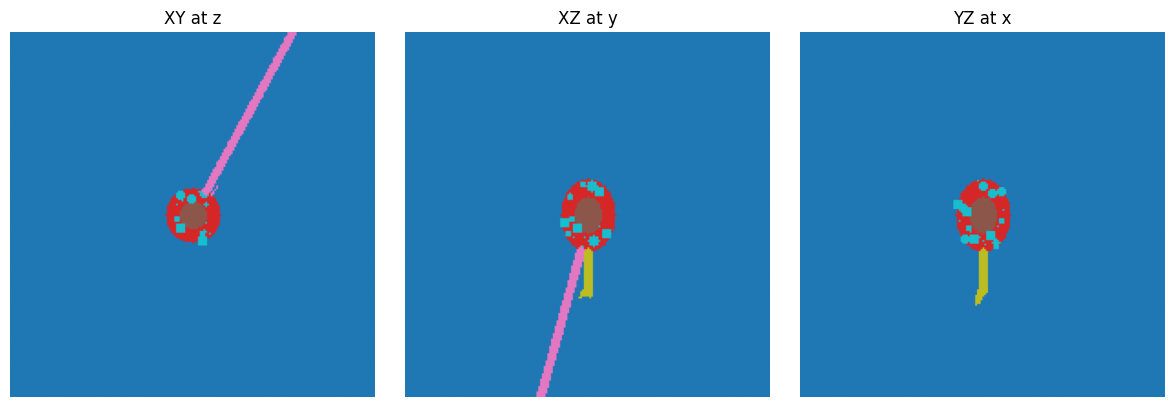

In [22]:
import numpy as np

def generate_synthetic_neuron3d(
    shape=(200,200,200),
    soma_center=None,
    soma_radii=(20,15,15),      # (rz, ry, rx) in voxels
    nucleus_ratio=0.5,
    num_mito=100,
    mito_radius_range=(1,3),
    num_dendrites=5,
    dend_depth=4,
    dend_length=200,
    dend_radius=2,
    axon_length=20,            # much longer by default
    axon_radius=2
):
    """
    Returns a (Z,Y,X) uint8 array with labels:
      0=background, 2=soma, 3=nucleus, 4=dendrites, 5=axon, 6=mitochondria
    """
    SOMA, NUC, DEND, AXON, MITO = 2,3,4,5,6
    nz, ny, nx = shape

    # center
    if soma_center is None:
        cz, cy, cx = nz//2, ny//2, nx//2
    else:
        cz, cy, cx = soma_center

    # grid coords
    zz, yy, xx = np.indices(shape)
    labels = np.zeros(shape, dtype=np.uint8)

    # 1) Ellipsoidal soma
    rz, ry, rx = soma_radii
    norm2 = ((zz-cz)/rz)**2 + ((yy-cy)/ry)**2 + ((xx-cx)/rx)**2
    mask_soma = norm2 <= 1.0
    labels[mask_soma] = SOMA

    # 2) Ellipsoidal nucleus
    mask_nuc = norm2 <= nucleus_ratio**2
    labels[mask_nuc] = NUC

    rng = np.random.default_rng()

    # 3) Mitochondria in soma shell
    for _ in range(num_mito):
        while True:
            dz, dy, dx = rng.uniform(-1,1,3)
            # pick random point in unit sphere
            if dz*dz+dy*dy+dx*dx <= 1:
                # scale to ellipsoid shell
                z0 = cz + dz*rz
                y0 = cy + dy*ry
                x0 = cx + dx*rx
                zi, yi, xi = int(round(z0)), int(round(y0)), int(round(x0))
                if (mask_soma[zi,yi,xi] and not mask_nuc[zi,yi,xi]):
                    break
        r_m = rng.integers(mito_radius_range[0], mito_radius_range[1]+1)
        labels[((zz-zi)**2 + (yy-yi)**2 + (xx-xi)**2) <= r_m**2] = MITO

    # helper: carve cylinder p0→p1
    def carve(p0, p1, rad, code):
        vec = p1-p0
        L = np.linalg.norm(vec)
        if L<1: return
        steps = int(np.ceil(L*2))
        for t in np.linspace(0,1,steps):
            pos = p0 + vec*t
            zi, yi, xi = np.round(pos).astype(int)
            for dz in range(-rad,rad+1):
                for dy in range(-rad,rad+1):
                    for dx in range(-rad,rad+1):
                        if dz*dz+dy*dy+dx*dx <= rad*rad:
                            z_,y_,x_ = zi+dz, yi+dy, xi+dx
                            if 0<=z_<nz and 0<=y_<ny and 0<=x_<nx:
                                labels[z_,y_,x_] = code

    # branching recursion
    def branch(p0, direction, depth, max_depth, length, radius, code):
        if depth>max_depth: return
        dirn = direction/np.linalg.norm(direction)
        p1 = p0 + dirn*length
        carve(p0, p1, radius, code)
        for _ in range(2):
            d2 = dirn + 0.5*rng.standard_normal(3)
            branch(p1, d2, depth+1, max_depth, length*0.7, max(radius-1,1), code)

    # 4) Dendrites on ellipsoid surface
    for _ in range(num_dendrites):
        # random direction on unit sphere
        v = rng.standard_normal(3)
        v /= np.linalg.norm(v)
        # start at ellipsoid surface: p = center + [v_z*rz, v_y*ry, v_x*rx]
        p0 = np.array([cz,cy,cx]) + np.array([v[0]*rz, v[1]*ry, v[2]*rx])
        branch(p0, v, 0, dend_depth, dend_length, dend_radius, DEND)

    # 5) Axon: long straight trunk plus one level of branching
    axdir = np.array([1.0,0,0])  # along +Z axis
    p0   = np.array([cz,cy,cx]) + axdir * rz
    # first draw trunk
    carve(p0, p0 + axdir*axon_length, axon_radius, AXON)
    # then a single branching step from the endpoint
    p_end = p0 + axdir*axon_length
    for _ in range(2):
        d2 = axdir + 0.5*rng.standard_normal(3)
        branch(p_end, d2, 1, 2, axon_length*0.5, axon_radius, AXON)

    return labels


# Example usage:
if __name__=="__main__":
    vol = generate_synthetic_neuron3d()
    # e.g. visualize three orthogonal slices:
    import matplotlib.pyplot as plt
    cz, cy, cx = np.array(vol.shape)//2
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(vol[cz], cmap='tab10'); ax[0].set_title('XY at z')
    ax[1].imshow(vol[:,cy,:], cmap='tab10'); ax[1].set_title('XZ at y')
    ax[2].imshow(vol[:,:,cx], cmap='tab10'); ax[2].set_title('YZ at x')
    for a in ax: a.axis('off')
    plt.tight_layout(); plt.show()


In [23]:
# 1) (Re)install dependencies if you don’t already have them
# !pip install scikit-image pythreejs

import numpy as np
from skimage import measure
from matplotlib import cm
from pythreejs import (
    PerspectiveCamera, Scene, Mesh, MeshLambertMaterial,
    AmbientLight, DirectionalLight, Renderer,
    BufferAttribute, BufferGeometry, OrbitControls
)

# 2) Generate or load your volume (Z,Y,X) of uint8 labels
# from your_module import generate_synthetic_neuron3d
# vol = generate_synthetic_neuron3d()
# For demo, assume vol is already in namespace.

# 3) Build a discrete color map for labels 2…6
max_lbl = int(vol.max())
cmap = cm.get_cmap('tab10', max_lbl+1)
# convert to hex strings
colors = [mpl.colors.to_hex(cmap(i)) for i in range(max_lbl+1)]

# 4) Create a Three.js scene
scene = Scene()

# Lights
scene.add(AmbientLight(color='#ffffff', intensity=0.5))
scene.add(DirectionalLight(color='#ffffff', intensity=0.6, position=[1,1,1]))

# For each label > 1, extract the surface and add a mesh
for lbl in range(2, max_lbl+1):
    verts, faces, normals, _ = measure.marching_cubes(vol, level=lbl-0.5)
    # verts: (N,3), faces:(M,3)
    # Build BufferGeometry
    geo = BufferGeometry(
        attributes={
            'position': BufferAttribute(verts.astype(np.float32), normalized=False),
            'index':    BufferAttribute(faces.astype(np.uint32).ravel(), normalized=False),
            'normal':   BufferAttribute(normals.astype(np.float32), normalized=False)
        }
    )
    mat = MeshLambertMaterial(color=colors[lbl], side='DoubleSide')
    mesh = Mesh(geometry=geo, material=mat)
    scene.add(mesh)

# 5) Camera & controls
camera = PerspectiveCamera(position=[vol.shape[2]*1.5, vol.shape[1]*1.5, vol.shape[0]*1.5],
                           up=[0,0,1], children=[AmbientLight(intensity=0.5)])
controls = OrbitControls(controlling=camera)

# 6) Renderer widget
renderer = Renderer(camera=camera,
                    scene=scene,
                    controls=[controls],
                    width=600, height=600)

renderer


/var/folders/76/vystmpks067f2s25992cn_8w0000gq/T/ipykernel_18831/1624098042.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Renderer(camera=PerspectiveCamera(children=(AmbientLight(intensity=0.5, position=(0.0, 0.0, 0.0), quaternion=(…